## Лабораторная работа 7
## Библиотека Scikit-Learn для анализа изображений, анализ рукописных цифр
## Водяный Михаил
## РИМ-181228

In [55]:
import seaborn as sns; sns.set()
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Анализ рукописных цифр

### Загрузка и визуализация цифр

Воспользуемся интерфейсом доступа к данным библиотеки Scikit-Learn и посмотрим на эти данные

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.images.shape

(1797, 8, 8)

Данные изображений представляют собой трехмерный массив: 1797 выборок,
каждая состоит из сетки пикселов размером 8 × 8. Визуализируем первую их сотню

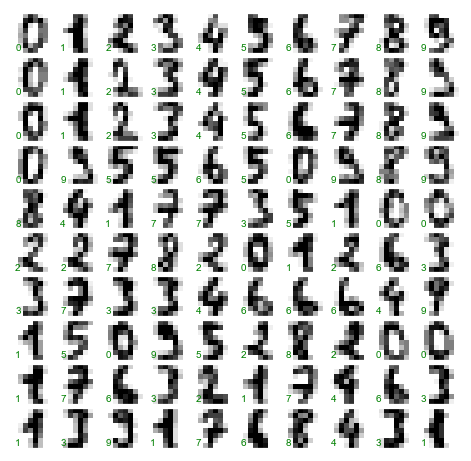

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
              interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In [5]:
X = digits.data
X.shape

(1797, 64)

In [6]:
y = digits.target
y.shape

(1797,)

Получаем 1797 выборок и 64 признака

### Обучение без учителя: понижение размерности

Преобразуем данные в двумерный вид:

In [7]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

Построим график этих данных, чтобы увидеть, можно ли что-то понять из их структуры

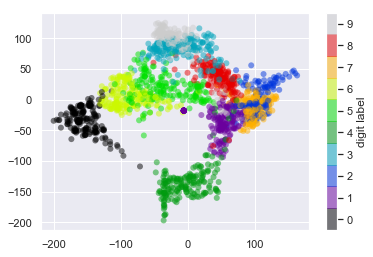

In [8]:
# Isomap-вложение набора данных цифр

plt.scatter(data_projected[:, 0], data_projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

## Классификация цифр

Применим алгоритм классификации к нашим цифрам

In [9]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [10]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Теперь, осуществив предсказания по нашей модели, мы можем оценить ее точность, сравнив настоящие значения из контрольной последовательности с предсказанными:

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

Из одного числа сложно понять, где наша модель ошиблась. Для этой цели удобна так называемая матрица различий (confusion matrix), вычислить которую можно с помощью библиотеки Scikit-Learn, а нарисовать посредством Seaborn

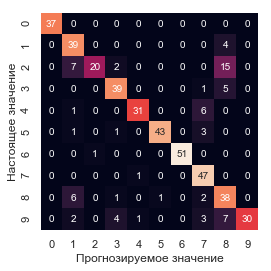

In [12]:
from sklearn.metrics import confusion_matrix

#Матрица различий, демонстрирующая частоты ошибочных классификаций нашего классификатора

mat = confusion_matrix(ytest, y_model)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('Прогнозируемое значение')
plt.ylabel('Настоящее значение'); 

Этот рисунок демонстрирует нам места, в которых наш классификатор склонен ошибаться, например, значительное количество двоек ошибочно классифицированы как единицы или восьмерки. 

Другой способ получения информации о характеристиках модели — построить график входных данных еще раз вместе с предсказанными метками.

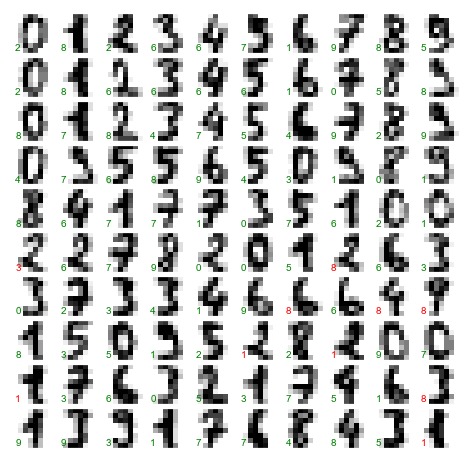

In [13]:
# Данные, показывающие правильные (зеленым цветом) и ошибочные (красным) метки
    
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
              interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')   

## Распознавание лиц

Воспользуемся набором данных Labeled Faces in the Wild1  (LFW), состоящим из  нескольких тысяч упорядоченных фотографий различных общественных деятелей. 

In [14]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Выведем на рисунок несколько из этих лиц, чтобы увидеть, с чем мы будем иметь дело

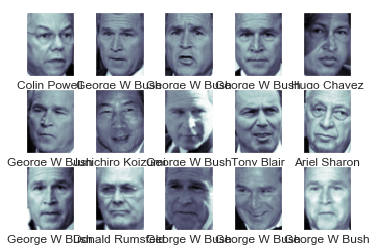

In [15]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Воспользуемся методом главных компонент для извлечения 150 базовых компонент, которые мы передадим нашему классификатору на основе метода опорных векторов.

Упростим эту задачу, объединив препроцессор и классификатор в единый конвейер:

In [16]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Для контроля результатов работы нашего классификатора разобьем данные на
обучающую и контрольную последовательности:

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Воспользуемся поиском по сетке с перекрестной проверкой для анализа сочетаний параметров. 

In [18]:
from sklearn.grid_search import GridSearchCV

param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 14.6 s
{'svc__C': 10, 'svc__gamma': 0.001}


Оптимальные значения приходятся на середину нашей сетки. 

Теперь с помощью этой, подвергнутой перекрестной проверке модели можно  предсказать метки для контрольных данных, которые модель еще не видела:

In [19]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Рассмотрим некоторые из контрольных изображений и предсказанных для них значений

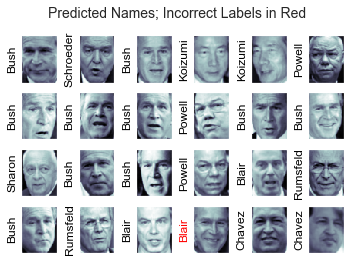

In [20]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
    fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [21]:
from sklearn.metrics import classification_report
    
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



Можем также вывести на экран матрицу различий между этими классами

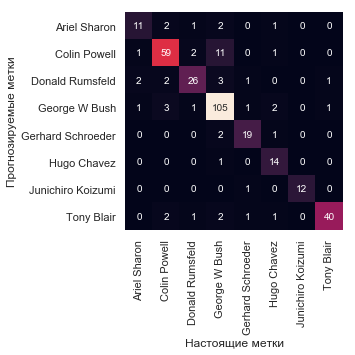

In [22]:
#Матрица различий для данных по лицам

mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Настоящие метки')
plt.ylabel('Прогнозируемые метки');

Эта информация позволяет нам понять, какие метки, вероятно, оцениватель определит неверно.

## Использование случайного леса для классификации цифр

In [23]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

В качестве напоминания, с чем мы имеем дело, визуализируем несколько первых
точек данных

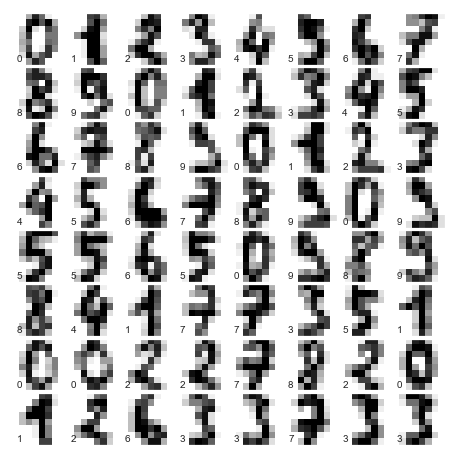

In [24]:
# Настройки рисунка
fig = plt.figure(figsize=(6, 6)) # размер рисунка в дюймах
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Рисуем цифры: размер каждого изображения 8 x 8 пикселов
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # Маркируем изображение целевыми значениями
    ax.text(0, 7, str(digits.target[i]))

Быстро классифицировать цифры с помощью случайного леса можно следующим образом

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Взглянем на отчет о классификации для данного классификатора:

In [26]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       0.98      0.93      0.95        45
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       0.98      1.00      0.99        51
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



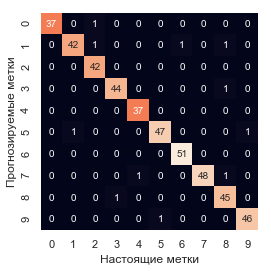

In [27]:
# матрица различий
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Настоящие метки')
plt.ylabel('Прогнозируемые метки');

## Использование Isomap для распознавания лиц

In [28]:
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

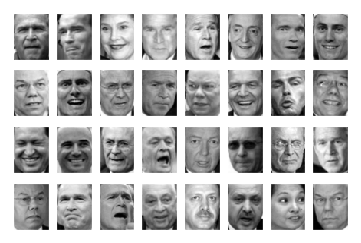

In [29]:
#Примеры исходных лиц

fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

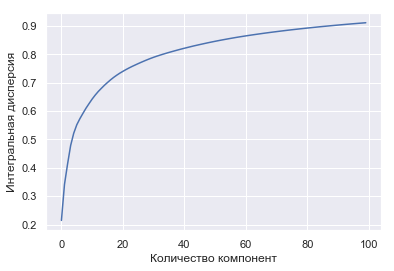

In [30]:
#Интегральная дисперсия, полученная из проекции методом PCA

model = PCA(svd_solver='randomized', n_components=100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('Количество компонент') 
plt.ylabel('Интегральная дисперсия'); 

Для сохранения 90% дисперсии необходимо почти 100 компонент. Это
значит, что данные имеют чрезвычайно высокую размерность и их
невозможно описать линейно с помощью всего нескольких компонент

В подобном случае могут оказаться полезны нелинейные вложения на базе многообразий, такие как LLE и Isomap.

In [31]:
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

Результат представляет собой двумерную проекцию всех исходных изображений.
Чтобы лучше представить, что говорит нам эта проекция, опишем функцию, выводящую миниатюры изображений в местах проекций:

In [32]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # Не отображаем слишком близко расположенные точки
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

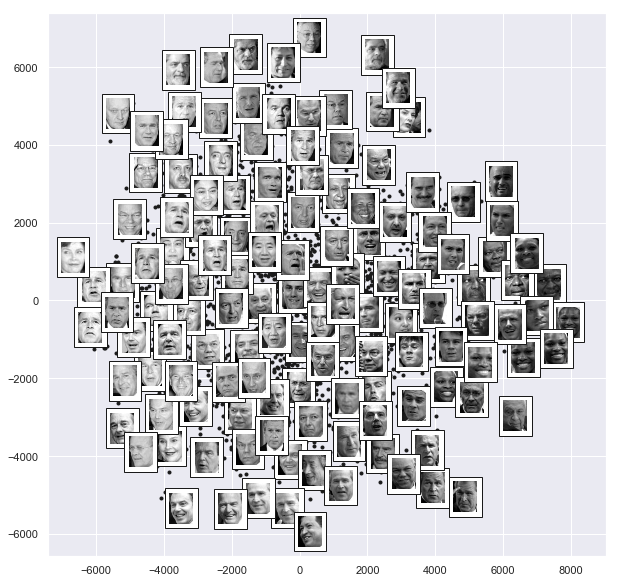

In [33]:
#Вложение с помощью Isomap данных о лицах

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

Результат интересен: первые два измерения Isomap, вероятно, описывают общие
признаки изображения: низкую или высокую яркость изображения слева направо
и общее расположение лица снизу вверх. 

## Визуализация структуры цифр

In [34]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

Этот набор состоит из 70 000 изображений, каждое размером 784 пиксела, то есть
28 × 28 пикселов. Рассмотрим несколько первых изображений

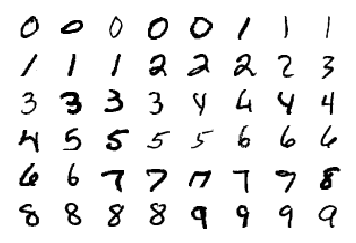

In [35]:
# Примеры цифр из набора MNIST

fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

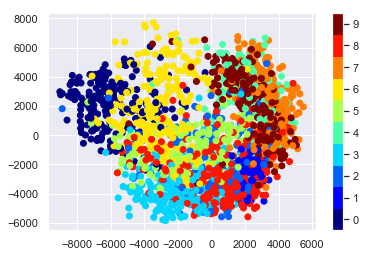

In [36]:
# Isomap-вложение для набора данных цифр MNIST

# используем только 1/30 часть данных:
# вычисления для полного набора данных занимают длительное время!
data = mnist.data[::30]
target = mnist.target[::30]
model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

Полученная диаграмма рассеяния демонстрирует некоторые зависимости между
точками данных, но точки на ней расположены слишком тесно. Можно получить
больше информации, изучая за раз данные лишь об одной цифре

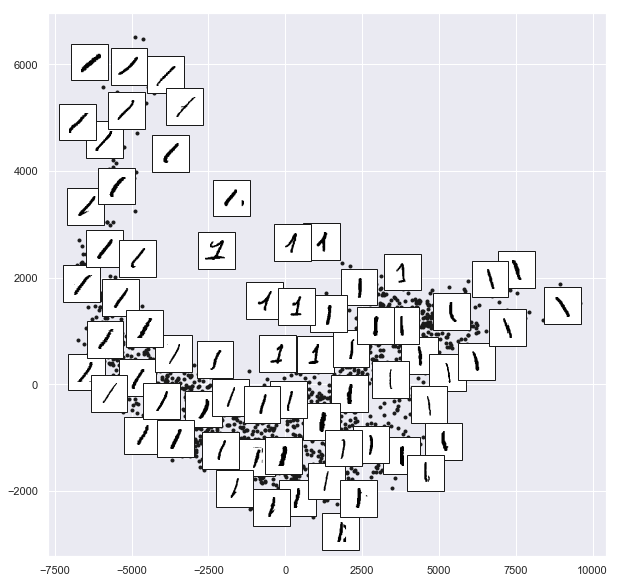

In [37]:
# Isomap-вложение только для единиц из набора данных о цифрах

# Выбираем для проекции 1/4 цифр "1"
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

Данные располагаются вдоль широкой кривой в пространстве проекции, отражающей ориентацию цифры. При перемещениивверх по графику мы видим единицы со «шляпками» и/или «подошвами», хотя они в этом наборе данных редки. 
Проекция дает нам возможность обнаружитьаномальные значения с проблемами в данных (например, части соседних цифр, попавших в извлеченные изображения).

## Конвейер распознавания лиц

### Признаки в методе HOG

Гистограмма направленных градиентов — простая процедура выделения признаков, разработанная для идентификации пешеходов на изображениях. 

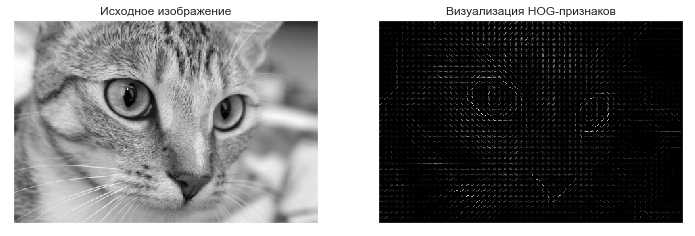

In [38]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Исходное изображение')
ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('Визуализация HOG-признаков');

In [39]:
#Получаем набор положительных обучающих выборок

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [40]:
#Получаем набор отрицательных обучающих выборок

from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
 'page', 'clock', 'immunohistochemistry',
 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
for name in imgs_to_use]

In [41]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches

In [42]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

У нас теперь есть 30 000 подходящих фрагментов изображений, не содержащих
лиц. Рассмотрим некоторые из них, чтобы лучше представить, как они выглядят 

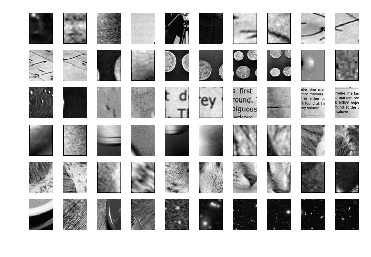

In [43]:
# Отрицательные фрагменты изображений, не содержащие лиц

fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [44]:
#Объединяем наборы и выделяем HOG-признаки

from itertools import chain

X_train = np.array([feature.hog(im)
for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [45]:
X_train.shape

(43233, 1215)

Итак, мы получили 43 000 обучающих выборок в 1215-мерном пространстве и наши данные находятся в подходящем для библиотеки Scikit-Learn виде

In [46]:
#Обучаем метод опорных векторов

from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.94094789, 0.87481785, 0.93969884])

Попробуем теперь метод опорных векторов с поиском по сетке из нескольких вариантов параметра C:

In [47]:
from sklearn.svm import LinearSVC

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.986584322161312

In [48]:
grid.best_params_

{'C': 4.0}

Обучим этот оптимальный оцениватель на полном наборе данных:

In [49]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

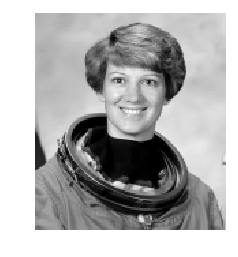

In [50]:
#Выполняем поиск лиц в новом изображении

test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray') #Изображение, в котором мы попытаемся найти лицо
plt.axis('off');

Далее создадим окно, которое будет перемещаться по фрагментам этого изображения с вычислением HOG-признаков для каждого фрагмента:

In [51]:
 def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
        Ni, Nj = (int(scale * s) for s in patch_size)
        for i in range(0, img.shape[0] - Ni, istep):
            for j in range(0, img.shape[1] - Ni, jstep):
                patch = img[i:i + Ni, j:j + Nj]
                if scale != 1:
                    patch = transform.resize(patch, patch_size)
                yield (i, j), patch

In [52]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

Наконец, возьмем эти фрагменты, для которых вычислены признаки HOG, и воспользуемся нашей моделью, чтобы определить, содержат ли какие-то из них лица:

In [53]:
labels = model.predict(patches_hog)
labels.sum()

33.0

Таким образом, среди 2000 фрагментов найдено 33 лица. 

Воспользуемся имеющейся о фрагментах информацией, чтобы определить, где в нашем контрольном изображении они располагаются, нарисовав их границы в виде прямоугольников

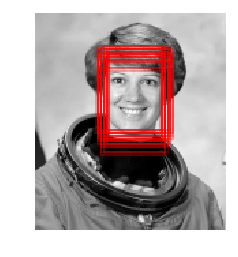

In [54]:
# Окна, в которых были обнаружены лица

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2,
                               facecolor='none'))

Все обнаруженные фрагменты перекрываются и содержат имеющееся на изображении лицо